In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from pdffuns2D3D import *

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

## Problem 1 ##
**Loading data from lab4.p**

In [4]:
pfile='lab4.p'
with open(pfile, 'rb') as fp:
    data=pickle.load(fp)

In [5]:
# Function to determine the confusion matrix
def confusion_matrix(C):
    M = len(C)
    A = np.zeros([M, M])
    for i in np.arange(0, M):
        for j in np.arange(0, M):
            A[i][j] = np.sum(C[i]==j)
    return A

# Function to calculate the Overall Accuracy (Ac)
def Ac(A):
    M = len(A)
    n = 0
    d = 0
    for i in np.arange(0, M):
        for j in np.arange(0, M):
            if i==j:
                n = n + A[i][j]
            d = d + A[i][j]
    if d==0:
        return 0
    else:
        return n/d
    
# Function to calculate the Recall (Ri)
def Ri(A, i):
    return A[i][i]/np.sum(A[i])

# Function to calculate the Precision (Pi)
def Pi(A, i):
    return A[i][i]/np.sum(A[:, i])

# Priori probability
def PrioriProbability(Y):
    M = len(Y)
    # Priori probability
    Pw = []
    for i in np.arange(0, M):
        Pw.append(Y[i].shape[1])
    Pw = np.array(Pw)
    Pw = Pw/np.sum(Pw)
    return Pw

def getMaxDiscriminantValuesIndex(g):
    # get the classification result for each feature vector in class i
    # for example: g(0)>g(1) ==> class 1, class 0 otherwise
    g_i = []
    for j in np.arange(0, len(g)):
        g_i.append(np.ravel(g[j]))
    return np.argmax(g_i, axis=0)

**ML Classifier:**

In [6]:
def MLClassifier(Y, X):
    # Number of classes
    M = len(Y)
    # Number of dimensions (2D, 3D)
    l = len(Y[0])
    
    # Priori probability
    Pw = PrioriProbability(Y)
    
    C = []
    for k in np.arange(0, M):
        g = []

        for i in np.arange(0, M):
            mu_i = np.mean(Y[i], axis=1)
            Sgm_i = np.cov(Y[i])
            x = []
            for j in np.arange(0, l):
                x.append(X[k][j].reshape(-1, 1))
            if l == 2:
                p = norm2D(mu_i, Sgm_i, x[0], x[1])
            elif l == 3:
                p = norm3D(mu_i, Sgm_i, x[0], x[1], x[2])

            g.append(Pw[i]*p)
        
        C.append(getMaxDiscriminantValuesIndex(g))
    
    return C

In [7]:
training_set = data[1]
test_set = data[0]

# Classify the training set for all classes
C = MLClassifier(training_set, training_set)
A_ML_re = confusion_matrix(C)

In [8]:
# Classify the test set for all classes
C = MLClassifier(training_set, test_set)
A_ML_te = confusion_matrix(C)

**Parzen-classifier:**

In [9]:
def ParzenClassifier(Y, X, h1):
    # Number of classes
    M = len(Y)
    # Number of dimensions (2D, 3D)
    l = len(Y[0])
    
    # Priori probability
    Pw = PrioriProbability(Y)
    
    C = []
    for k in np.arange(0, M):
        g = []
        for i in np.arange(0, M):
            x = []
            for j in np.arange(0, l):
                x.append(X[k][j].reshape(-1, 1))
               
            N = Y[i].shape[1]
            if l == 2:
                Xi = np.array(list(zip(Y[i][0], Y[i][1])))
                p = Parzen2D(h1, N, Xi, x[0], x[1])
            elif l == 3:
                Xi = np.array(list(zip(Y[i][0], Y[i][1], Y[i][2])))
                p = Parzen3D(h1, N, Xi, x[0], x[1], x[2])
            g.append(Pw[i]*p)
            
        C.append(getMaxDiscriminantValuesIndex(g))
        
    return C

**Parzen-classifier with h1=0.1**

In [10]:
# Classify the training set for all classes
C = ParzenClassifier(training_set, training_set, h1=0.1)
A_Parz_01_re = confusion_matrix(C)

In [11]:
# Classify the test set for all classes
C = ParzenClassifier(training_set, test_set, h1=0.1)
A_Parz_01_te = confusion_matrix(C)

**Parzen-classifier with h1=5**

In [12]:
# Classify the training set for all classes
C = ParzenClassifier(training_set, training_set, h1=5)
A_Parz_5_re = confusion_matrix(C)

In [13]:
# Classify the test set for all classes
C = ParzenClassifier(training_set, test_set, h1=5)
A_Parz_5_te = confusion_matrix(C)

**Comment the results**  
From the classification results table below, we can see that with h1=0.1, the reclassification error rate (0.00) is much lower than the error rate found when classifying the test data (0.20), this indicates that the classifier is overtrained. With h1=5, the reclassification error rate and testing error rate are close (0.08 vs 0.06), the percentages of correct classifying increase on test set and testing error rate decrease (from 0.20 to 0.06). As the window functions are wider, the contribution from the samples furthest away gets more.

#### $k_n$-nearest neighbor classifier:

In [14]:
def KNNClassifier(Y, X, kN):
    # Number of classes
    M = len(Y)
    # Number of dimensions (2D, 3D)
    l = len(Y[0])
    
    # Priori probability
    Pw = PrioriProbability(Y)
    
    C = []
    for k in np.arange(0, M):
        g = []
        for i in np.arange(0, M):
            x = []
            for j in np.arange(0, l):
                x.append(X[k][j].reshape(-1, 1))
               
            N = Y[i].shape[1]
            if l == 2:
                Xi = np.array(list(zip(Y[i][0], Y[i][1])))
                p = KNN2D(kN, N, Xi, x[0], x[1])
            elif l == 3:
                Xi = np.array(list(zip(Y[i][0], Y[i][1], Y[i][2])))
                p = KNN3D(kN, N, Xi, x[0], x[1], x[2])
            g.append(Pw[i]*p)
            
        C.append(getMaxDiscriminantValuesIndex(g))
        
    return C

#### $k_n$-nearest neighbor classifier with $k_n=1$

In [15]:
# Classify the training set for all classes
C = KNNClassifier(training_set, training_set, kN=1)
A_KNN_1_re = confusion_matrix(C)

In [16]:
# Classify the test set for all classes
C = KNNClassifier(training_set, test_set, kN=1)
A_KNN_1_te = confusion_matrix(C)

**Comment the results**  
From the classification results table below, we can see that with kn=1, the reclassification error rate equals to 0, lower than the error rate found when classifying the test data (0.08). The testing error rate is not bad and the percentages of correct classifying on test set are much better than Parzen Classifier with h1=0.1

#### $k_n$-nearest neighbor classifier with $k_n=5$

In [17]:
# Classify the training set for all classes
C = KNNClassifier(training_set, training_set, kN=5)
A_KNN_5_re = confusion_matrix(C)

In [18]:
# Classify the test set for all classes
C = KNNClassifier(training_set, test_set, kN=5)
A_KNN_5_te = confusion_matrix(C)

**Comment the results**  
From the classification results table below, we can see that with kn=5, the reclassification error rate and testing error rate are closer (0.09 vs 0.07), the percentages of correct classifying on test set increase and testing error rate decrease a bit (from 0.08 to 0.07) compared to with kn=1.

### The classification results

In [19]:
print("Classifier                            | P(error) | P(correct|w1) | P(correct|w2)")
print(("ML reclassification                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_ML_re), Ri(A_ML_re, 0), Ri(A_ML_re, 1)))
print(("ML testing                            |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_ML_te), Ri(A_ML_te, 0), Ri(A_ML_te, 1)))
print(("Parzen h1=0.1 reclassification        |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_Parz_01_re), Ri(A_Parz_01_re, 0), Ri(A_Parz_01_re, 1)))
print(("Parzen h1=0.1 testing                 |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_Parz_01_te), Ri(A_Parz_01_te, 0), Ri(A_Parz_01_te, 1)))
print(("Parzen h1=5 reclassification          |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_Parz_5_re), Ri(A_Parz_5_re, 0), Ri(A_Parz_5_re, 1)))
print(("Parzen h1=5 testing                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_Parz_5_te), Ri(A_Parz_5_te, 0), Ri(A_Parz_5_te, 1)))
print(("Nearest neighbor kn=1 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_KNN_1_re), Ri(A_KNN_1_re, 0), Ri(A_KNN_1_re, 1)))
print(("Nearest neighbor kn=1 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_KNN_1_te), Ri(A_KNN_1_te, 0), Ri(A_KNN_1_te, 1)))
print(("Nearest neighbor kn=5 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_KNN_5_re), Ri(A_KNN_5_re, 0), Ri(A_KNN_5_re, 1)))
print(("Nearest neighbor kn=5 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}").format(
        1-Ac(A_KNN_5_te), Ri(A_KNN_5_te, 0), Ri(A_KNN_5_te, 1)))

Classifier                            | P(error) | P(correct|w1) | P(correct|w2)
ML reclassification                   |   0.10   |   0.93        |    0.85
ML testing                            |   0.05   |   0.97        |    0.94
Parzen h1=0.1 reclassification        |   0.00   |   1.00        |    1.00
Parzen h1=0.1 testing                 |   0.20   |   0.91        |    0.64
Parzen h1=5 reclassification          |   0.08   |   0.93        |    0.91
Parzen h1=5 testing                   |   0.06   |   0.95        |    0.93
Nearest neighbor kn=1 reclassification|   0.00   |   1.00        |    1.00
Nearest neighbor kn=1 testing         |   0.08   |   0.95        |    0.86
Nearest neighbor kn=5 reclassification|   0.09   |   0.93        |    0.89
Nearest neighbor kn=5 testing         |   0.07   |   0.93        |    0.91


## Problem 2

**Loading data from lab4_2.p**

In [20]:
pfile = 'lab4_2.p'
with open(pfile, "rb") as fp:
    (X_2D3cl , X_2D4cl , X_2D4cl_ms , X_2D4cl_hs , X_3D3cl_ms, 
     Y_2D3cl , Y_2D4cl , Y_2D4cl_ms , Y_2D4cl_hs , Y_3D3cl_ms) = pickle.load(fp)

In [21]:
def plotData(training_set, test_set, training_set_title, test_set_title):
    M = len(training_set)
    l = len(training_set[0])
    classes = np.arange(0, M)
    markers = ["s", "o", "x", "v"]
    
    fig = plt.figure(figsize = (16, 8))
    if l==2:
        ax = fig.add_subplot(121)
    elif l==3:
        ax = fig.add_subplot(121, projection='3d')
    ax.set_title(training_set_title)
    for i in classes:
        if l==2:
            ax.scatter(training_set[i][0], training_set[i][1], marker=markers[i])
        elif l==3:
            ax.scatter(training_set[i][0], training_set[i][1], training_set[i][2], marker=markers[i])
            
    ax.legend(list(map(lambda x: "Class w{0}".format(x+1), classes)))
    ax.grid()
    
    if l==2:
        ax = fig.add_subplot(122)
    elif l==3:
        ax = fig.add_subplot(122, projection='3d')
    ax.set_title(test_set_title)
    for i in classes:
        if l==2:
            ax.scatter(test_set[i][0], test_set[i][1], marker=markers[i])
        elif l==3:
            ax.scatter(test_set[i][0], test_set[i][1], test_set[i][2], marker=markers[i])
    ax.legend(list(map(lambda x: "Class w{0}".format(x+1), classes)))
    ax.grid()
    
def classify(training_set, test_set):
    # ML Classifier
    # Classify the training set for all classes
    C = MLClassifier(training_set, training_set)
    A_ML_re = confusion_matrix(C)
    # Classify the test set for all classes
    C = MLClassifier(training_set, test_set)
    A_ML_te = confusion_matrix(C)
    
    # Parzen Classifier h1=0.1
    # Classify the training set for all classes
    C = ParzenClassifier(training_set, training_set, h1=0.1)
    A_Parz_01_re = confusion_matrix(C)
    # Classify the test set for all classes
    C = ParzenClassifier(training_set, test_set, h1=0.1)
    A_Parz_01_te = confusion_matrix(C)
    
    # Parzen Classifier h1=5
    # Classify the training set for all classes
    C = ParzenClassifier(training_set, training_set, h1=5)
    A_Parz_5_re = confusion_matrix(C)
    # Classify the test set for all classes
    C = ParzenClassifier(training_set, test_set, h1=5)
    A_Parz_5_te = confusion_matrix(C)
    
    # k-nearest neighbor classifier with kn=1
    # Classify the training set for all classes
    C = KNNClassifier(training_set, training_set, kN=1)
    A_KNN_1_re = confusion_matrix(C)
    # Classify the test set for all classes
    C = KNNClassifier(training_set, test_set, kN=1)
    A_KNN_1_te = confusion_matrix(C)
    
    # k-nearest neighbor classifier with kn=5
    # Classify the training set for all classes
    C = KNNClassifier(training_set, training_set, kN=5)
    A_KNN_5_re = confusion_matrix(C)
    # Classify the test set for all classes
    C = KNNClassifier(training_set, test_set, kN=5)
    A_KNN_5_te = confusion_matrix(C)
    
    # The tables showing the results
    M = len(training_set)
    if M==3:
        print("Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3)")
        print(("ML reclassification                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_ML_re), Ri(A_ML_re, 0), Ri(A_ML_re, 1), Ri(A_ML_re, 2)))
        print(("ML testing                            |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_ML_te), Ri(A_ML_te, 0), Ri(A_ML_te, 1), Ri(A_ML_te, 2)))
        print(("Parzen h1=0.1 reclassification        |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_Parz_01_re), Ri(A_Parz_01_re, 0), Ri(A_Parz_01_re, 1), Ri(A_Parz_01_re, 2)))
        print(("Parzen h1=0.1 testing                 |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_Parz_01_te), Ri(A_Parz_01_te, 0), Ri(A_Parz_01_te, 1), Ri(A_Parz_01_te, 2)))
        print(("Parzen h1=5 reclassification          |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_Parz_5_re), Ri(A_Parz_5_re, 0), Ri(A_Parz_5_re, 1), Ri(A_Parz_5_re, 2)))
        print(("Parzen h1=5 testing                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_Parz_5_te), Ri(A_Parz_5_te, 0), Ri(A_Parz_5_te, 1), Ri(A_Parz_5_te, 2)))
        print(("Nearest neighbor kn=1 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_KNN_1_re), Ri(A_KNN_1_re, 0), Ri(A_KNN_1_re, 1), Ri(A_KNN_1_re, 2)))
        print(("Nearest neighbor kn=1 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_KNN_1_te), Ri(A_KNN_1_te, 0), Ri(A_KNN_1_te, 1), Ri(A_KNN_1_te, 2)))
        print(("Nearest neighbor kn=5 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_KNN_5_re), Ri(A_KNN_5_re, 0), Ri(A_KNN_5_re, 1), Ri(A_KNN_5_re, 2)))
        print(("Nearest neighbor kn=5 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}").format(
                1-Ac(A_KNN_5_te), Ri(A_KNN_5_te, 0), Ri(A_KNN_5_te, 1), Ri(A_KNN_5_te, 2)))
    elif M==4:
        print("Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3) | P(correct|w4)")
        print(("ML reclassification                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_ML_re), Ri(A_ML_re, 0), Ri(A_ML_re, 1), Ri(A_ML_re, 2), Ri(A_ML_re, 3)))
        print(("ML testing                            |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_ML_te), Ri(A_ML_te, 0), Ri(A_ML_te, 1), Ri(A_ML_te, 2), Ri(A_ML_te, 3)))
        print(("Parzen h1=0.1 reclassification        |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_Parz_01_re), Ri(A_Parz_01_re, 0), Ri(A_Parz_01_re, 1), Ri(A_Parz_01_re, 2), Ri(A_Parz_01_re, 3)))
        print(("Parzen h1=0.1 testing                 |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_Parz_01_te), Ri(A_Parz_01_te, 0), Ri(A_Parz_01_te, 1), Ri(A_Parz_01_te, 2), Ri(A_Parz_01_te, 3)))
        print(("Parzen h1=5 reclassification          |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_Parz_5_re), Ri(A_Parz_5_re, 0), Ri(A_Parz_5_re, 1), Ri(A_Parz_5_re, 2), Ri(A_Parz_5_re, 3)))
        print(("Parzen h1=5 testing                   |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_Parz_5_te), Ri(A_Parz_5_te, 0), Ri(A_Parz_5_te, 1), Ri(A_Parz_5_te, 2), Ri(A_Parz_5_te, 3)))
        print(("Nearest neighbor kn=1 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_KNN_1_re), Ri(A_KNN_1_re, 0), Ri(A_KNN_1_re, 1), Ri(A_KNN_1_re, 2), Ri(A_KNN_1_re, 3)))
        print(("Nearest neighbor kn=1 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_KNN_1_te), Ri(A_KNN_1_te, 0), Ri(A_KNN_1_te, 1), Ri(A_KNN_1_te, 2), Ri(A_KNN_1_te, 3)))
        print(("Nearest neighbor kn=5 reclassification|   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_KNN_5_re), Ri(A_KNN_5_re, 0), Ri(A_KNN_5_re, 1), Ri(A_KNN_5_re, 2), Ri(A_KNN_5_re, 3)))
        print(("Nearest neighbor kn=5 testing         |   {0:.2f}   |   {1:.2f}        |    {2:.2f}       |    {3:.2f}       |    {4:.2f}").format(
                1-Ac(A_KNN_5_te), Ri(A_KNN_5_te, 0), Ri(A_KNN_5_te, 1), Ri(A_KNN_5_te, 2), Ri(A_KNN_5_te, 3)))

**a) Make scatter plot and classify the 2D 3 class data set**

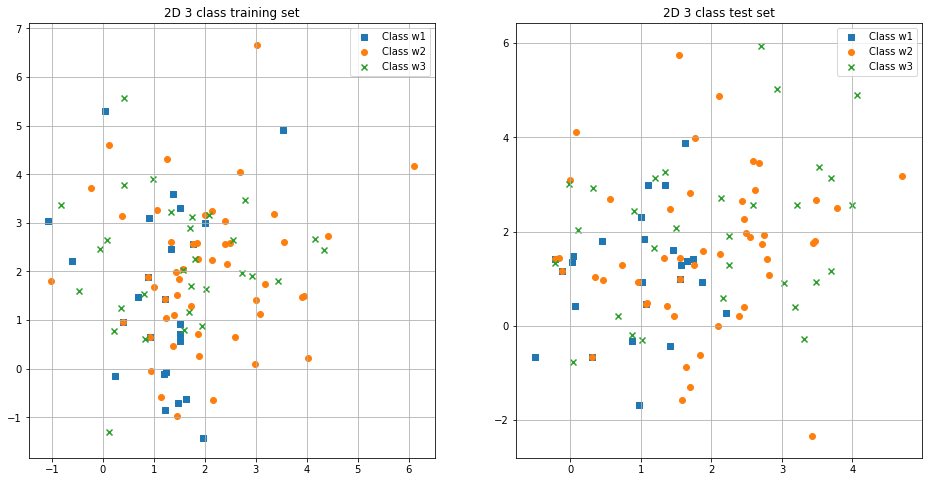

In [22]:
plotData(Y_2D3cl, X_2D3cl, "2D 3 class training set", "2D 3 class test set")

In [23]:
classify(Y_2D3cl, X_2D3cl)

Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3)
ML reclassification                   |   0.47   |   0.32        |    0.86       |    0.17
ML testing                            |   0.53   |   0.24        |    0.78       |    0.13
Parzen h1=0.1 reclassification        |   0.05   |   0.80        |    1.00       |    1.00
Parzen h1=0.1 testing                 |   0.63   |   0.52        |    0.26       |    0.43
Parzen h1=5 reclassification          |   0.46   |   0.16        |    0.96       |    0.17
Parzen h1=5 testing                   |   0.53   |   0.16        |    0.82       |    0.13
Nearest neighbor kn=1 reclassification|   0.05   |   1.00        |    0.90       |    1.00
Nearest neighbor kn=1 testing         |   0.66   |   0.32        |    0.38       |    0.30
Nearest neighbor kn=5 reclassification|   0.52   |   0.36        |    0.74       |    0.13
Nearest neighbor kn=5 testing         |   0.55   |   0.36        |    0.64       |  

**b) Make scatter plot and classify the 2D 4 class data set**

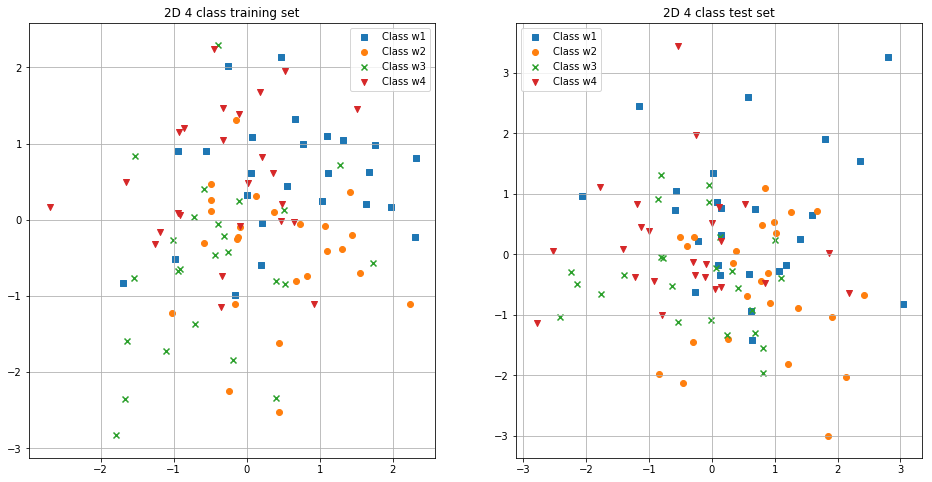

In [24]:
plotData(Y_2D4cl, X_2D4cl, "2D 4 class training set", "2D 4 class test set")

In [25]:
classify(Y_2D4cl, X_2D4cl)

Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3) | P(correct|w4)
ML reclassification                   |   0.48   |   0.52        |    0.56       |    0.44       |    0.56
ML testing                            |   0.63   |   0.28        |    0.52       |    0.28       |    0.40
Parzen h1=0.1 reclassification        |   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Parzen h1=0.1 testing                 |   0.69   |   0.40        |    0.40       |    0.12       |    0.32
Parzen h1=5 reclassification          |   0.46   |   0.52        |    0.64       |    0.48       |    0.52
Parzen h1=5 testing                   |   0.62   |   0.24        |    0.52       |    0.36       |    0.40
Nearest neighbor kn=1 reclassification|   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Nearest neighbor kn=1 testing         |   0.69   |   0.32        |    0.48       |    0.12       |    0.32
Nearest neighbor kn=5 reclassif

**c) Make scatter plot and classify the 2D 4 class data set with medium separability**

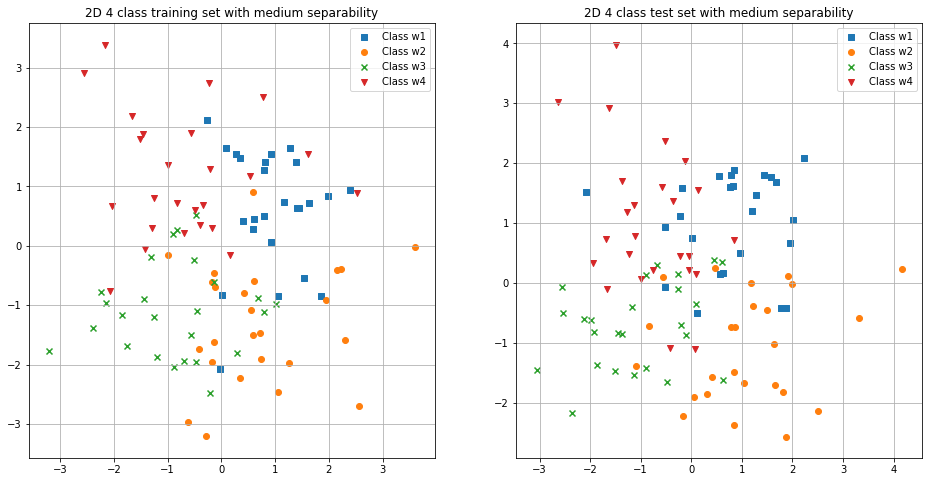

In [26]:
plotData(Y_2D4cl_ms, X_2D4cl_ms, 
         "2D 4 class training set with medium separability", 
         "2D 4 class test set with medium separability")

In [27]:
classify(Y_2D4cl_ms, X_2D4cl_ms)

Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3) | P(correct|w4)
ML reclassification                   |   0.29   |   0.72        |    0.72       |    0.68       |    0.72
ML testing                            |   0.29   |   0.64        |    0.64       |    0.76       |    0.80
Parzen h1=0.1 reclassification        |   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Parzen h1=0.1 testing                 |   0.43   |   0.64        |    0.48       |    0.48       |    0.68
Parzen h1=5 reclassification          |   0.28   |   0.80        |    0.68       |    0.68       |    0.72
Parzen h1=5 testing                   |   0.28   |   0.76        |    0.64       |    0.72       |    0.76
Nearest neighbor kn=1 reclassification|   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Nearest neighbor kn=1 testing         |   0.42   |   0.60        |    0.48       |    0.52       |    0.72
Nearest neighbor kn=5 reclassif

**d) Make scatter plot and classify the 2D 4 class data set with high separability**

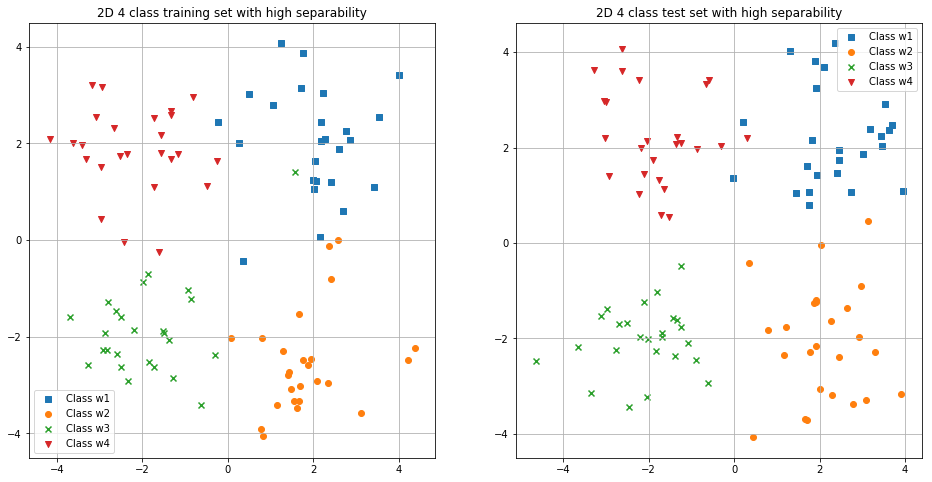

In [28]:
plotData(Y_2D4cl_hs, X_2D4cl_hs, 
         "2D 4 class training set with high separability", 
         "2D 4 class test set with high separability")

In [29]:
classify(Y_2D4cl_hs, X_2D4cl_hs)

Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3) | P(correct|w4)
ML reclassification                   |   0.07   |   0.92        |    0.88       |    0.96       |    0.96
ML testing                            |   0.05   |   0.96        |    0.88       |    1.00       |    0.96
Parzen h1=0.1 reclassification        |   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Parzen h1=0.1 testing                 |   0.12   |   0.88        |    0.80       |    0.92       |    0.92
Parzen h1=5 reclassification          |   0.05   |   0.96        |    0.92       |    0.96       |    0.96
Parzen h1=5 testing                   |   0.05   |   0.96        |    0.88       |    1.00       |    0.96
Nearest neighbor kn=1 reclassification|   0.00   |   1.00        |    1.00       |    1.00       |    1.00
Nearest neighbor kn=1 testing         |   0.08   |   0.88        |    0.88       |    0.96       |    0.96
Nearest neighbor kn=5 reclassif

**Explain the difference in results comparing subtasks b-d.**  
The classification results corresponds to data set with high separability is better than the data set with medium separability and much better than the data set without separability.  
With mot separable dataset, the discriminant function values will be more different and the model can learn and classify more correct.

**e) Make scatter plot and classify the 3D 3 class problem with medium separability**

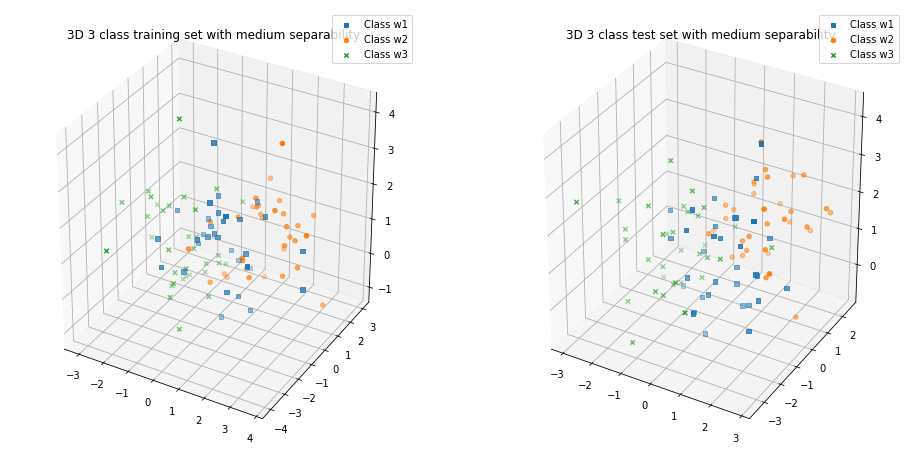

In [30]:
plotData(Y_3D3cl_ms, X_3D3cl_ms, 
         "3D 3 class training set with medium separability", 
         "3D 3 class test set with medium separability")

In [31]:
classify(Y_3D3cl_ms, X_3D3cl_ms)

Classifier                            | P(error) | P(correct|w1) | P(correct|w2) | P(correct|w3)
ML reclassification                   |   0.21   |   0.67        |    0.85       |    0.85
ML testing                            |   0.17   |   0.91        |    0.85       |    0.73
Parzen h1=0.1 reclassification        |   0.00   |   1.00        |    1.00       |    1.00
Parzen h1=0.1 testing                 |   0.48   |   0.91        |    0.21       |    0.42
Parzen h1=5 reclassification          |   0.17   |   0.76        |    0.82       |    0.91
Parzen h1=5 testing                   |   0.20   |   0.85        |    0.82       |    0.73
Nearest neighbor kn=1 reclassification|   0.00   |   1.00        |    1.00       |    1.00
Nearest neighbor kn=1 testing         |   0.33   |   0.82        |    0.55       |    0.64
Nearest neighbor kn=5 reclassification|   0.21   |   0.67        |    0.79       |    0.91
Nearest neighbor kn=5 testing         |   0.21   |   0.85        |    0.82       |  